In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from fredapi import Fred
import datetime
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score

# Initialize FRED API
fred = Fred(api_key='8445855393be6d75a6d33bcddffc7958')


In [51]:

# Define the series IDs for the required data 
series_ids = {
    '5-Year, 5-Year Forward Inflation Expectation Rate': 'T5YIFR',
    '1 Year Treasury Rate': 'DGS1',
    'fed_balance_sheet_assets': 'WALCL',
    'gdp': 'GDP',
    'Summary of Economic Projections: Longer-Term Federal Funds Rate': 'FEDTARMDLR',
    'US 10yr': 'DGS10',
    'RRP': "WLRRAL",
    'US Treasury General Account' : 'D2WLTGAL'
}

# Fetch the data starting from 11/8/2021
start_date = '2012-01-03'

# Download data and store in a dictionary
data = {name: fred.get_series(series_id, observation_start=start_date) for name, series_id in series_ids.items()}

# Convert the dictionary to a DataFrame
df = pd.DataFrame(data)

# Resample the monthly GDP to daily frequency using forward fill method
df = df.ffill()

# Calculate the Fed Balance Sheet Assets to GDP ratio
df['Fed BS Assets to GDP'] = df['fed_balance_sheet_assets'] / (df['gdp'] * 1000)

# Calculate Net Liquidity Indicator
df['Net Liquidity Indicator'] = df['fed_balance_sheet_assets'] - df['RRP'] - df['US Treasury General Account']

# Drop unnecessary columns
df = df.drop(['fed_balance_sheet_assets', 'gdp', 'RRP', 'US Treasury General Account'], axis=1)
df = df.dropna()



In [52]:
# Calculate percent changes over various time horizons\n",
time_horizons = [5, 20, 60]
for column in df.columns:
    if column not in ['Date', 'Target']:
        df[f'{column}_pct_change_5'] = df[column].pct_change(periods=5) * 100
        df[f'{column}_pct_change_20'] = df[column].pct_change(periods=20) * 100
        df[f'{column}_pct_change_60'] = df[column].pct_change(periods=60) * 100

In [53]:
df_orig = df.copy()
# Define the target variable and the features
X = df.drop(columns=['US 10yr'])
y = df['US 10yr']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the regression tree and the parameter grid for grid search
reg_tree = DecisionTreeRegressor(random_state=42)
param_grid = {
    'max_depth': [3,4],
    'min_samples_split': [10, 25],
    'min_samples_leaf': [ 10, 25]
}


In [54]:

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=reg_tree, param_grid=param_grid, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)
# Get the best model
best_tree = grid_search.best_estimator_
print(best_tree)

DecisionTreeRegressor(max_depth=4, min_samples_leaf=10, min_samples_split=10,
                      random_state=42)


Model Parameters: {'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 4, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 10, 'min_samples_split': 10, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': 42, 'splitter': 'best'}
R^2: 0.9350601070408724
Adjusted R^2: 0.9346171599655284
Current 10-Year Yield: 4.67
Current 10-Year Yield Prediction: 4.388
Percentile rank of the latest value: 88.35%


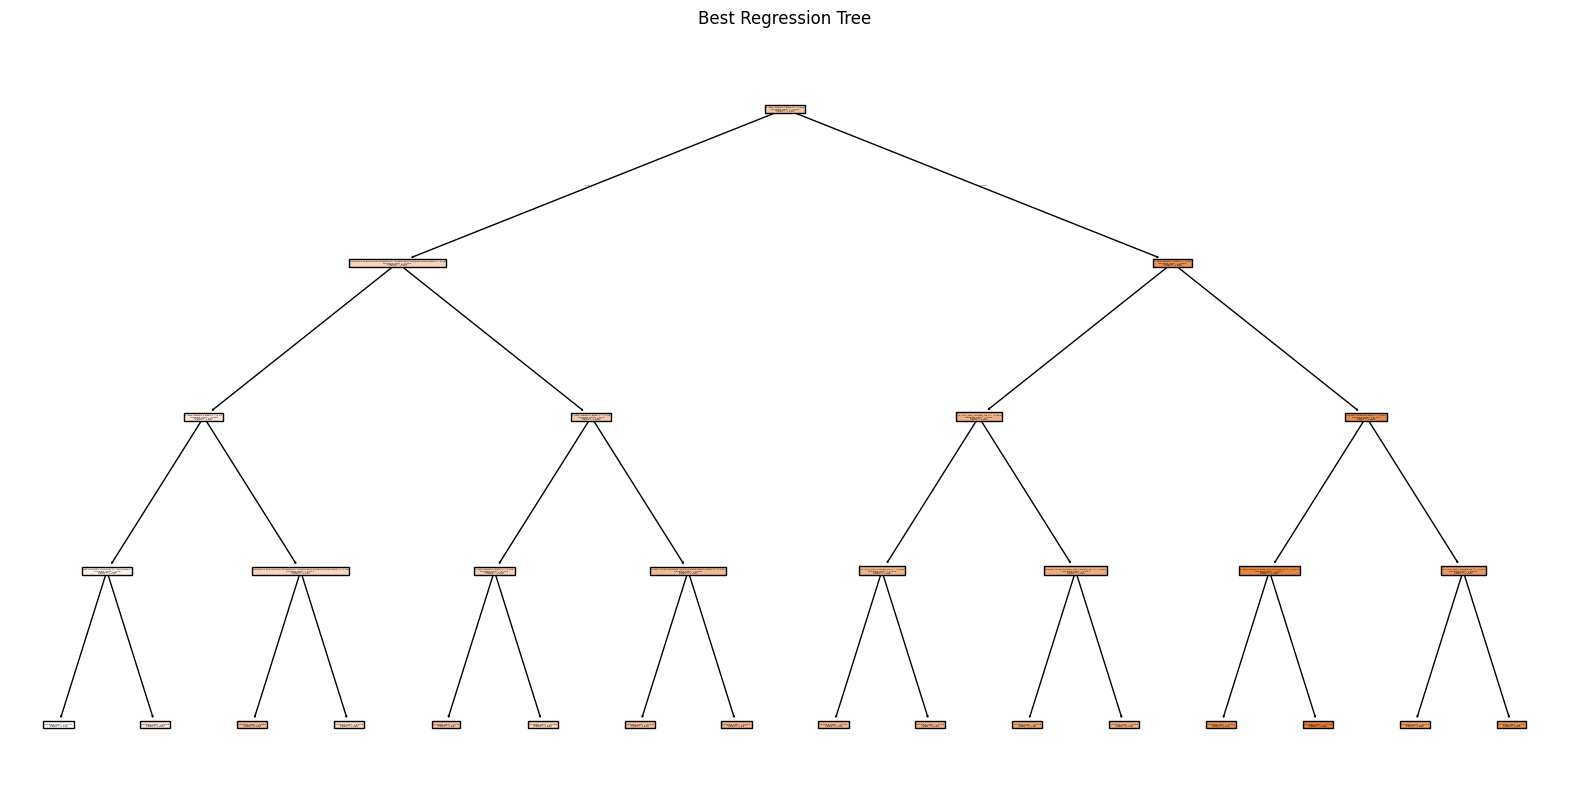

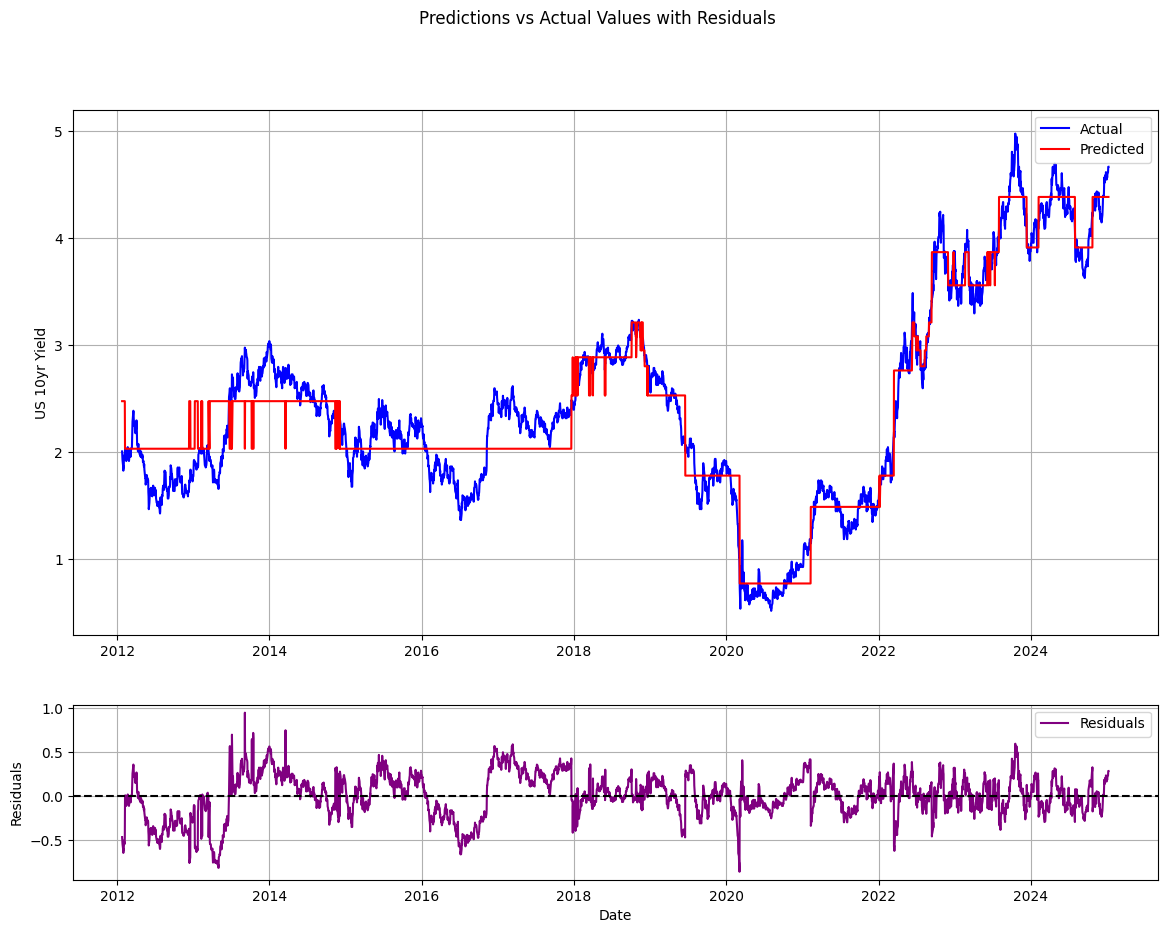

In [55]:
from sklearn.metrics import r2_score

# Make predictions on the test set
y_pred = best_tree.predict(X_test)
y_pred_all = best_tree.predict(X)  # Predictions on the entire dataset for metrics calculation

# Calculate R-squared and adjusted R-squared
r_squared = r2_score(y, y_pred_all)
n = X.shape[0]  # Number of observations
k = X.shape[1]  # Number of predictors
adjusted_r_squared = 1 - (1 - r_squared) * (n - 1) / (n - k - 1)

# Display regression information and latest difference
print(f"Model Parameters: {best_tree.get_params()}")
print(f"R^2: {r_squared}")
print(f"Adjusted R^2: {adjusted_r_squared}")
print(f"Current 10-Year Yield: {round(y.iloc[-1], 4)}")
print(f"Current 10-Year Yield Prediction: {round(y_pred_all[-1], 4)}")

# Calculate residuals
residuals = y - y_pred_all

# Calculate the percentile rank for each value in the series
df['residuals'] = residuals
df['residual percentile_rank'] = df['residuals'].rank(pct=True) * 100

# Display the percentile rank for the latest value in the series
latest_value = df['residuals'].iloc[-1]
latest_percentile_rank = df['residual percentile_rank'].iloc[-1]
print(f"Percentile rank of the latest value: {latest_percentile_rank:.2f}%")

# Plot the best regression tree
plt.figure(figsize=(20, 10))
plot_tree(best_tree, feature_names=X.columns, filled=True)
plt.title('Best Regression Tree')
plt.show()

# Plot predictions and actual values
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), gridspec_kw={'height_ratios': [3, 1]})
fig.suptitle('Predictions vs Actual Values with Residuals')

# Plot predictions and actual values on the same chart
ax1.plot(df.index, y, label='Actual', color='blue')
ax1.plot(df.index, y_pred_all, label='Predicted', color='red')
ax1.set_ylabel('US 10yr Yield')
ax1.legend()
ax1.grid(True)

# Plot residuals
ax2.plot(df.index, residuals, label='Residuals', color='purple')
ax2.set_ylabel('Residuals')
ax2.axhline(y=0, color='black', linestyle='--')
ax2.legend()
ax2.grid(True)

plt.xlabel('Date')
plt.show()

In [56]:
df.tail(5)

,"5-Year, 5-Year Forward Inflation Expectation Rate",1 Year Treasury Rate,Summary of Economic Projections: Longer-Term Federal Funds Rate,US 10yr,Fed BS Assets to GDP,Net Liquidity Indicator,"5-Year, 5-Year Forward Inflation Expectation Rate_pct_change_5","5-Year, 5-Year Forward Inflation Expectation Rate_pct_change_20","5-Year, 5-Year Forward Inflation Expectation Rate_pct_change_60",1 Year Treasury Rate_pct_change_5,...,US 10yr_pct_change_20,US 10yr_pct_change_60,Fed BS Assets to GDP_pct_change_5,Fed BS Assets to GDP_pct_change_20,Fed BS Assets to GDP_pct_change_60,Net Liquidity Indicator_pct_change_5,Net Liquidity Indicator_pct_change_20,Net Liquidity Indicator_pct_change_60,residuals,residual percentile_rank
2025-01-02,2.27,4.17,3.0,4.57,0.233277,5242204.0,-1.731602,5.581395,-5.416667,-1.418440,...,9.592326,11.735941,-0.48609,-0.628438,-2.75796,-6.131024,-5.259998,-5.035082,0.182036,76.825677
2025-01-03,2.28,4.18,3.0,4.60,0.233277,5242204.0,-0.869565,5.069124,-5.394191,-0.476190,...,10.843373,12.745098,-0.48609,-0.628438,-2.75796,-6.131024,-5.259998,-5.035082,0.212036,80.800942
2025-01-06,2.28,4.17,3.0,4.62,0.233277,5242204.0,0.440529,3.167421,-5.394191,0.000000,...,10.000000,13.235294,-0.48609,-0.628438,-2.75796,-6.131024,-5.259998,-5.035082,0.232036,83.303887
2025-01-07,2.32,4.19,3.0,4.67,0.233277,5242204.0,0.869565,3.571429,-0.854701,0.721154,...,10.663507,15.880893,-0.48609,-0.628438,-2.75796,-6.131024,-5.259998,-5.035082,0.282036,88.353946
2025-01-08,2.33,4.19,3.0,4.67,0.233277,5242204.0,1.304348,4.954955,-0.851064,0.721154,...,9.624413,16.169154,0.00000,-0.652325,-2.65358,0.000000,-6.219186,-5.639690,0.282036,88.353946


## Time-Series Cross Validation

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score



In [58]:
#reg_tree = DecisionTreeRegressor(random_state=42)

# Define the target variable and the features
df['US 10yr lead'] = df['US 10yr'].shift(-20)
df = df.dropna()
X = df.drop(columns=['residuals','residual percentile_rank','US 10yr lead'])
#X = df.drop(columns=['US 10yr lead'])
y = df['US 10yr lead']

# Split the data into training and testing sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
param_grid = {
    'max_depth': [ 6,8,10,12],
    'min_samples_split': [10,20,50],
    'min_samples_leaf': [10,20,50],
    'max_leaf_nodes': [None,10,20]
}


In [59]:
initial_train_size = int(0.75 * y.shape[0])  # Set your desired initial train size here
tscv = TimeSeriesSplit(n_splits=df.shape[0] - initial_train_size, test_size=1)



In [60]:
# for i, (train_index, test_index) in enumerate(tscv.split(X)):
#     print(f"Fold {i}:")
#     print(f"  Train: index={train_index}")
#     print(f"  Test:  index={test_index}")

In [61]:
best_score = float('inf')
best_params = None

# Initialize a pandas Series to store out-of-sample predictions with the same index as y
oof_predictions = pd.Series(index=y.index, dtype=float)

# Perform grid search with cross-validation
for train_index, test_index in tscv.split(X):
    if len(train_index) >= initial_train_size:
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        grid_search = GridSearchCV(estimator=reg_tree, param_grid=param_grid, scoring='neg_mean_squared_error', n_jobs=-1)
        grid_search.fit(X_train, y_train)
        
        if grid_search.best_score_ < best_score:
            best_score = grid_search.best_score_
            best_params = grid_search.best_params_
        
        # Make predictions on the test set
        y_pred = grid_search.predict(X_test)
        
        # Store the predictions in the corresponding indices using iloc
        oof_predictions.iloc[test_index] = y_pred

best_tree = DecisionTreeRegressor(**best_params, random_state=42)
best_tree.fit(X, y)

print("Best hyperparameters:", best_params)


Best hyperparameters: {'max_depth': 8, 'max_leaf_nodes': 20, 'min_samples_leaf': 50, 'min_samples_split': 10}


In [62]:
scores = []
for train_index, test_index in tscv.split(X):
    if len(train_index) >= initial_train_size:
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        best_tree.fit(X_train, y_train)
        y_pred = best_tree.predict(X_test)
        scores.append(mean_squared_error(y_test, y_pred))
    
print(f"Mean MSE: {np.mean(scores)}")

Mean MSE: 0.07991949080396522


In [63]:
import joblib

# Save the trained model to a file
joblib.dump(best_tree, 'US10YR_decision_tree_model.pkl')


['US10YR_decision_tree_model.pkl']

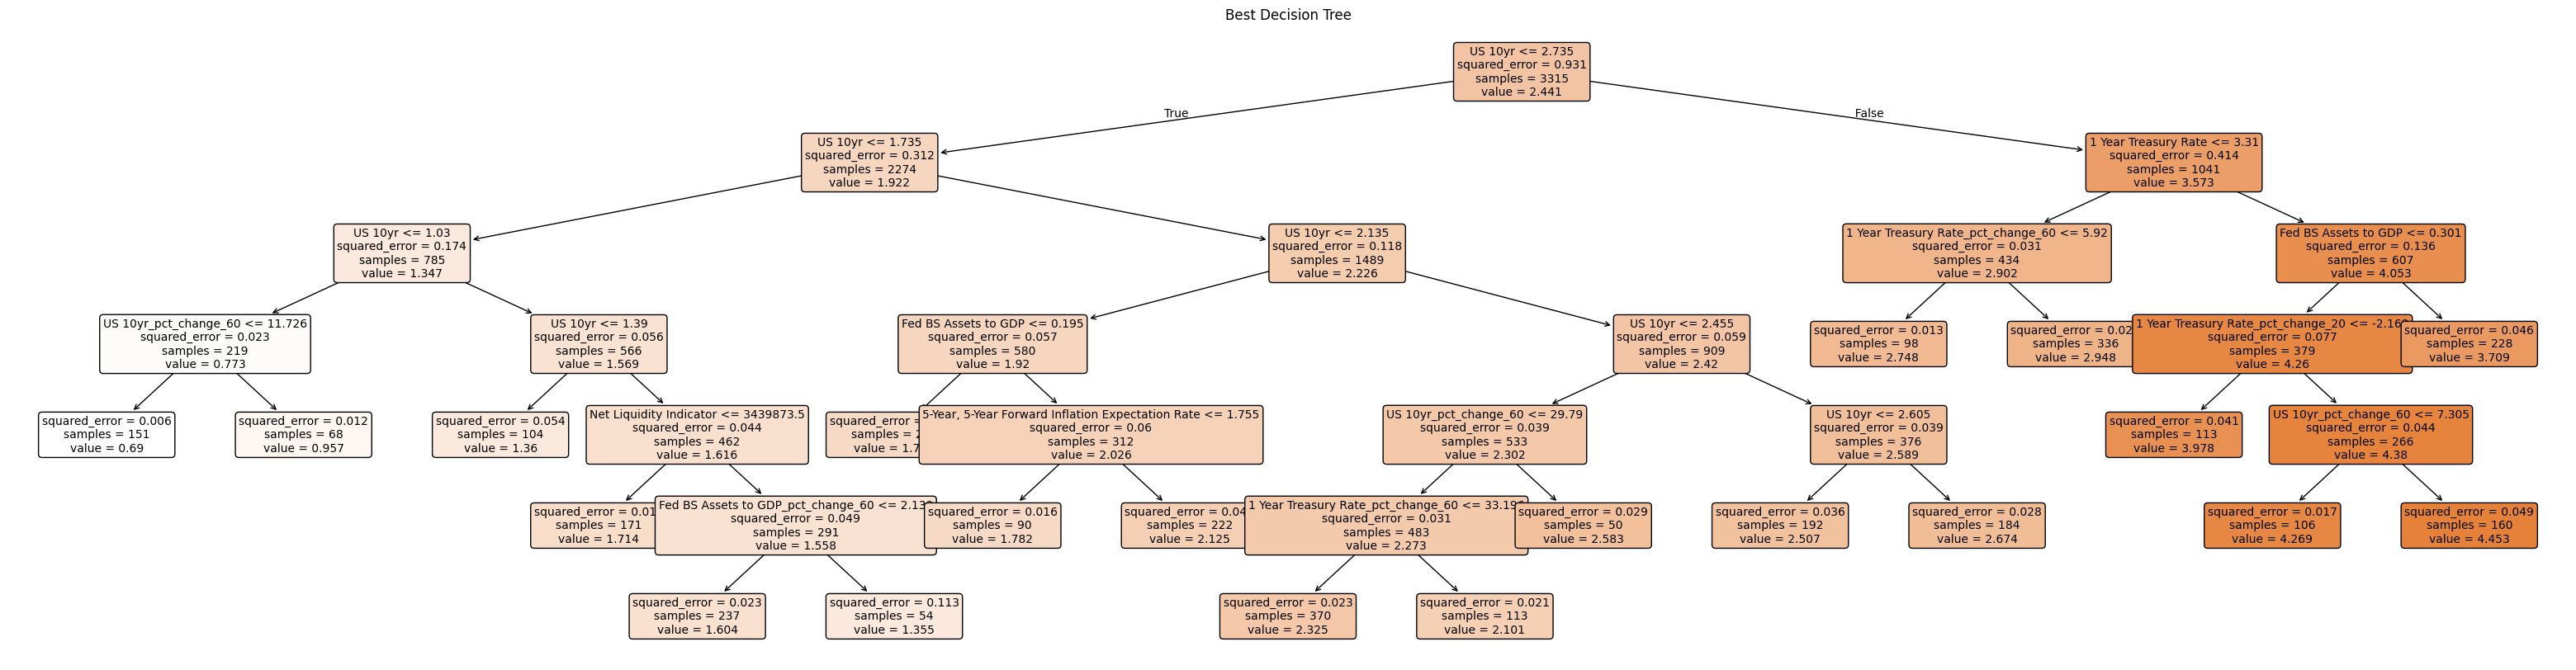

In [64]:
plt.figure(figsize=(40, 10))  # Adjust the size of the plot as necessary
plot_tree(best_tree, feature_names=X.columns, filled=True, rounded=True, fontsize=10)
plt.title("Best Decision Tree")
plt.show()


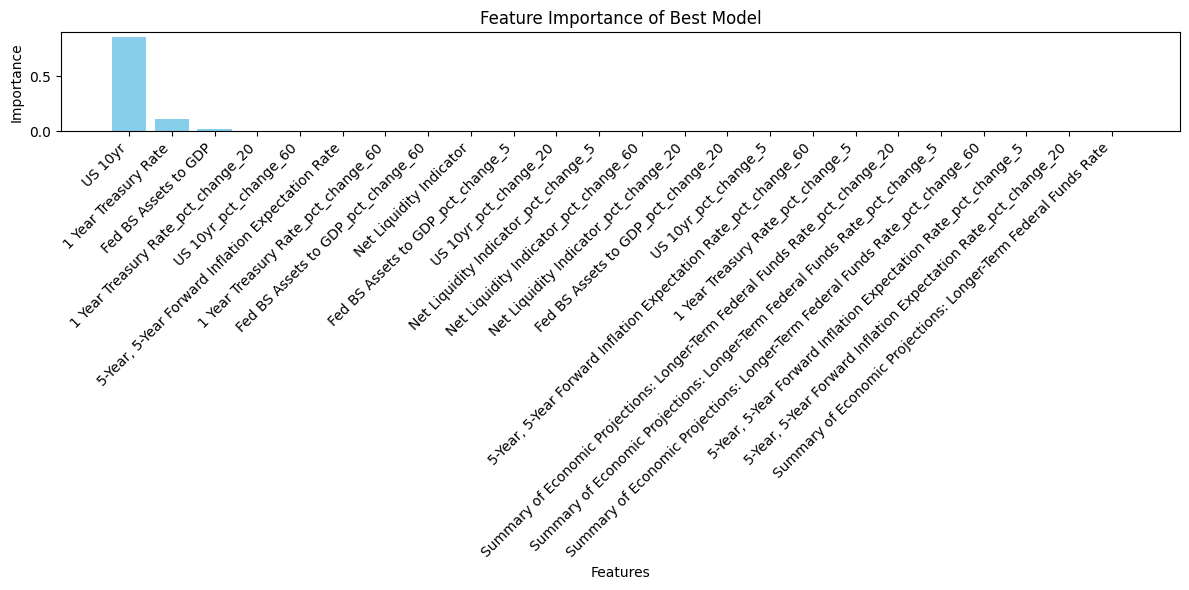

In [65]:
# Get feature importances
importances = best_tree.feature_importances_
features = X.columns

# Sort the importances in descending order
indices = np.argsort(importances)[::-1]

# Plot the feature importances
plt.figure(figsize=(12, 6))  # Increased figure size
plt.bar(features[indices], importances[indices], color='skyblue')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance of Best Model')
plt.xticks(rotation=45, ha='right')  # Rotated x-axis labels
plt.tight_layout()
plt.show()

In [66]:
df_orig[X.columns]

,"5-Year, 5-Year Forward Inflation Expectation Rate",1 Year Treasury Rate,Summary of Economic Projections: Longer-Term Federal Funds Rate,US 10yr,Fed BS Assets to GDP,Net Liquidity Indicator,"5-Year, 5-Year Forward Inflation Expectation Rate_pct_change_5","5-Year, 5-Year Forward Inflation Expectation Rate_pct_change_20","5-Year, 5-Year Forward Inflation Expectation Rate_pct_change_60",1 Year Treasury Rate_pct_change_5,...,Summary of Economic Projections: Longer-Term Federal Funds Rate_pct_change_60,US 10yr_pct_change_5,US 10yr_pct_change_20,US 10yr_pct_change_60,Fed BS Assets to GDP_pct_change_5,Fed BS Assets to GDP_pct_change_20,Fed BS Assets to GDP_pct_change_60,Net Liquidity Indicator_pct_change_5,Net Liquidity Indicator_pct_change_20,Net Liquidity Indicator_pct_change_60
2012-01-25,2.43,0.12,4.3,2.01,0.181690,2718892.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-26,2.38,0.12,4.3,1.96,0.181690,2718892.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-27,2.34,0.12,4.3,1.93,0.181690,2718892.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-30,2.35,0.12,4.3,1.87,0.181690,2718892.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-31,2.34,0.13,4.3,1.83,0.181690,2718892.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-02,2.27,4.17,3.0,4.57,0.233277,5242204.0,-1.731602,5.581395,-5.416667,-1.418440,...,3.448276,-0.218341,9.592326,11.735941,-0.48609,-0.628438,-2.75796,-6.131024,-5.259998,-5.035082
2025-01-03,2.28,4.18,3.0,4.60,0.233277,5242204.0,-0.869565,5.069124,-5.394191,-0.476190,...,3.448276,-0.432900,10.843373,12.745098,-0.48609,-0.628438,-2.75796,-6.131024,-5.259998,-5.035082
2025-01-06,2.28,4.17,3.0,4.62,0.233277,5242204.0,0.440529,3.167421,-5.394191,0.000000,...,3.448276,1.538462,10.000000,13.235294,-0.48609,-0.628438,-2.75796,-6.131024,-5.259998,-5.035082
2025-01-07,2.32,4.19,3.0,4.67,0.233277,5242204.0,0.869565,3.571429,-0.854701,0.721154,...,3.448276,1.965066,10.663507,15.880893,-0.48609,-0.628438,-2.75796,-6.131024,-5.259998,-5.035082


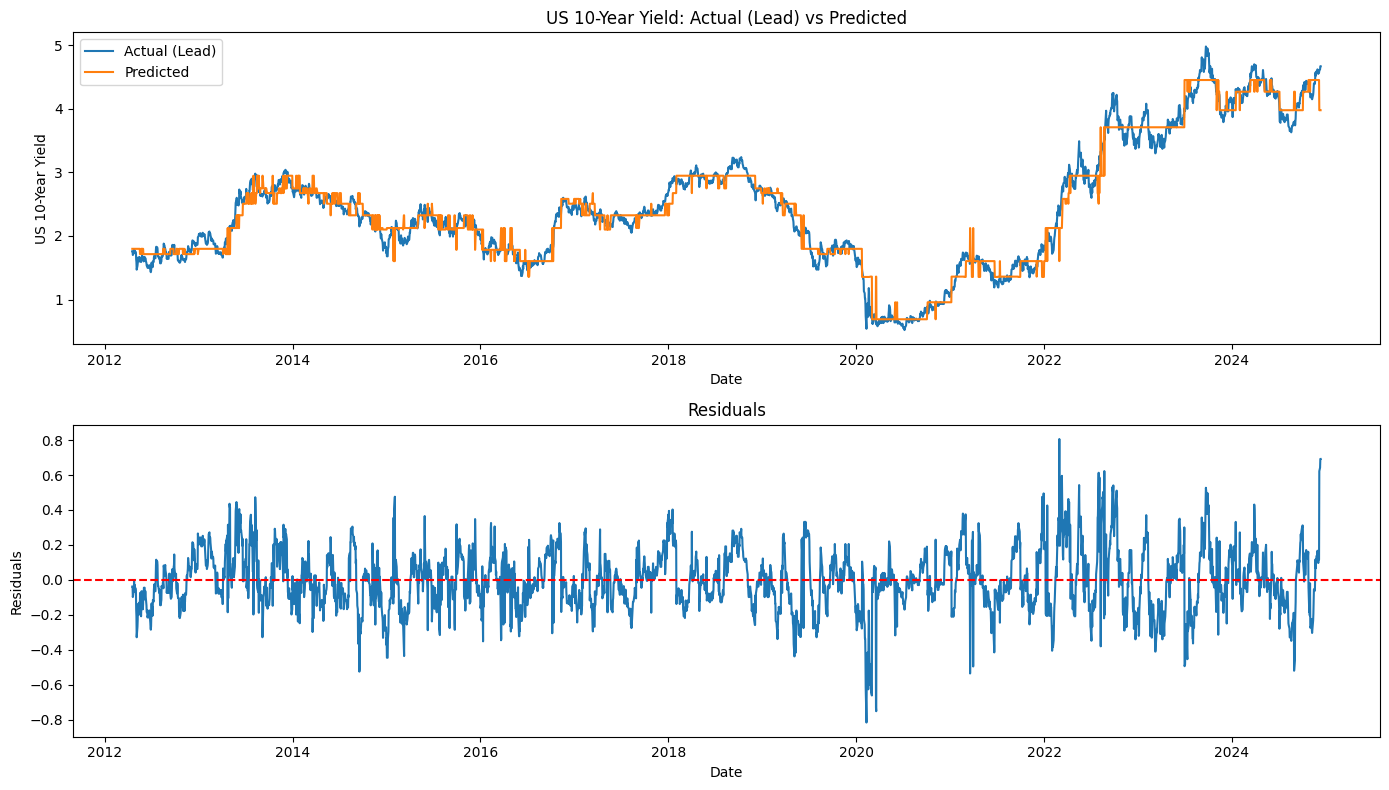

Model Parameters: {'max_depth': 8, 'max_leaf_nodes': 20, 'min_samples_leaf': 50, 'min_samples_split': 10}
R^2: 0.9677693881890657
Adjusted R^2: 0.967534342706397
Current 10-Year Yield: 4.67
Current 10-Year Yield Prediction: 3.9781
Percentile rank of the latest value: 99.95%


In [67]:
import matplotlib.dates as mdates

# Make predictions for the entire dataset
y_pred_all = best_tree.predict(X)

plt.figure(figsize=(14, 8))

# Plot actual vs predicted
plt.subplot(2, 1, 1)
plt.plot(df.index, y, label='Actual (Lead)')
plt.plot(df.index, y_pred_all, label='Predicted')
plt.title('US 10-Year Yield: Actual (Lead) vs Predicted')
plt.xlabel('Date')
plt.ylabel('US 10-Year Yield')
plt.legend()

# Calculate residuals
residuals = y - y_pred_all

# Plot residuals
plt.subplot(2, 1, 2)
plt.plot(df.index, residuals, label='Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals')
plt.xlabel('Date')
plt.ylabel('Residuals')

plt.tight_layout()
plt.show()

# Calculate R^2 and Adjusted R^2
r_squared = r2_score(y, y_pred_all)
n = X.shape[0]  # Number of observations
k = X.shape[1]  # Number of predictors
adjusted_r_squared = 1 - (1 - r_squared) * (n - 1) / (n - k - 1)

# Calculate residuals
residuals = y - y_pred_all
df['residuals'] = residuals

# Calculate the percentile rank for each value in the series
df['residual percentile_rank'] = df['residuals'].rank(pct=True) * 100

# Retrieve the latest values
current_yield = round(y.iloc[-1], 4)
current_yield_prediction = round(y_pred_all[-1], 4)
latest_diff = round(current_yield - current_yield_prediction, 4)
latest_percentile_rank = df['residual percentile_rank'].iloc[-1]

# Display metrics
print(f"Model Parameters: {best_params}")
print(f"R^2: {r_squared}")
print(f"Adjusted R^2: {adjusted_r_squared}")
print(f"Current 10-Year Yield: {current_yield}")
print(f"Current 10-Year Yield Prediction: {current_yield_prediction}")
print(f"Percentile rank of the latest value: {latest_percentile_rank:.2f}%")

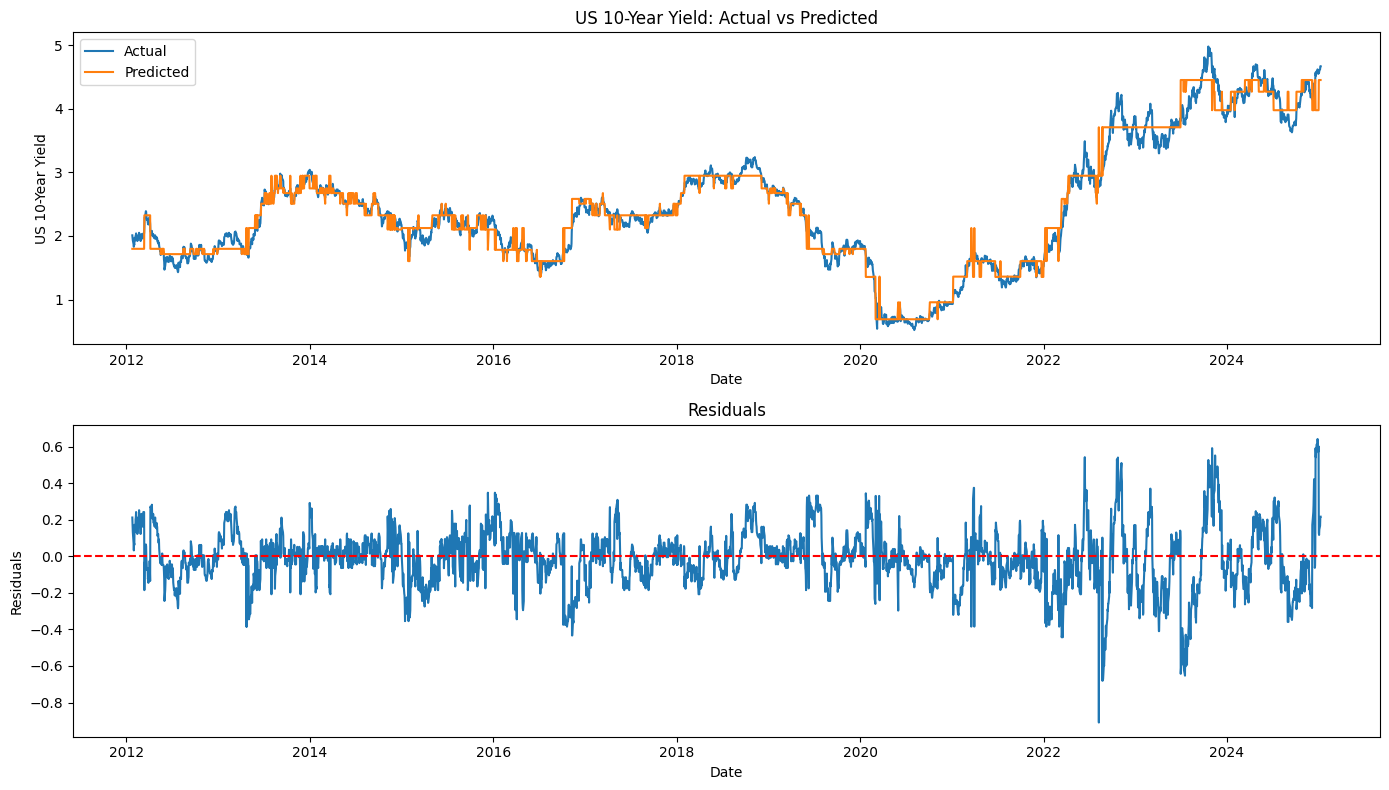

Model Parameters: {'max_depth': 8, 'max_leaf_nodes': 20, 'min_samples_leaf': 50, 'min_samples_split': 10}
R^2: 0.9677693881890657
Adjusted R^2: 0.967534342706397
Current 10-Year Yield: 4.67
Current 10-Year Yield Prediction: 4.4529


In [68]:
import matplotlib.dates as mdates

# Make predictions for the entire dataset
y_pred_all = best_tree.predict(df_orig[X.columns])


plt.figure(figsize=(14, 8))

# Plot actual vs predicted
plt.subplot(2, 1, 1)
plt.plot(df_orig.index, df_orig['US 10yr'], label='Actual')
plt.plot(df_orig.index, y_pred_all, label='Predicted')
plt.title('US 10-Year Yield: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('US 10-Year Yield')
plt.legend(loc = 'upper left')
plt.tight_layout()
#plt.show()
# Calculate residuals
residuals = df_orig['US 10yr'] - y_pred_all

# Plot residuals
plt.subplot(2, 1, 2)
plt.plot(df_orig.index, residuals, label='Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals')
plt.xlabel('Date')
plt.ylabel('Residuals')

plt.tight_layout()
plt.show()
# Retrieve the latest values
current_yield = round(df_orig['US 10yr'].iloc[-1], 4)
current_yield_prediction = round(y_pred_all[-1], 4)
latest_diff = round(current_yield - current_yield_prediction, 4)

# Display metrics
print(f"Model Parameters: {best_params}")
print(f"R^2: {r_squared}")
print(f"Adjusted R^2: {adjusted_r_squared}")
print(f"Current 10-Year Yield: {current_yield}")
print(f"Current 10-Year Yield Prediction: {current_yield_prediction}")

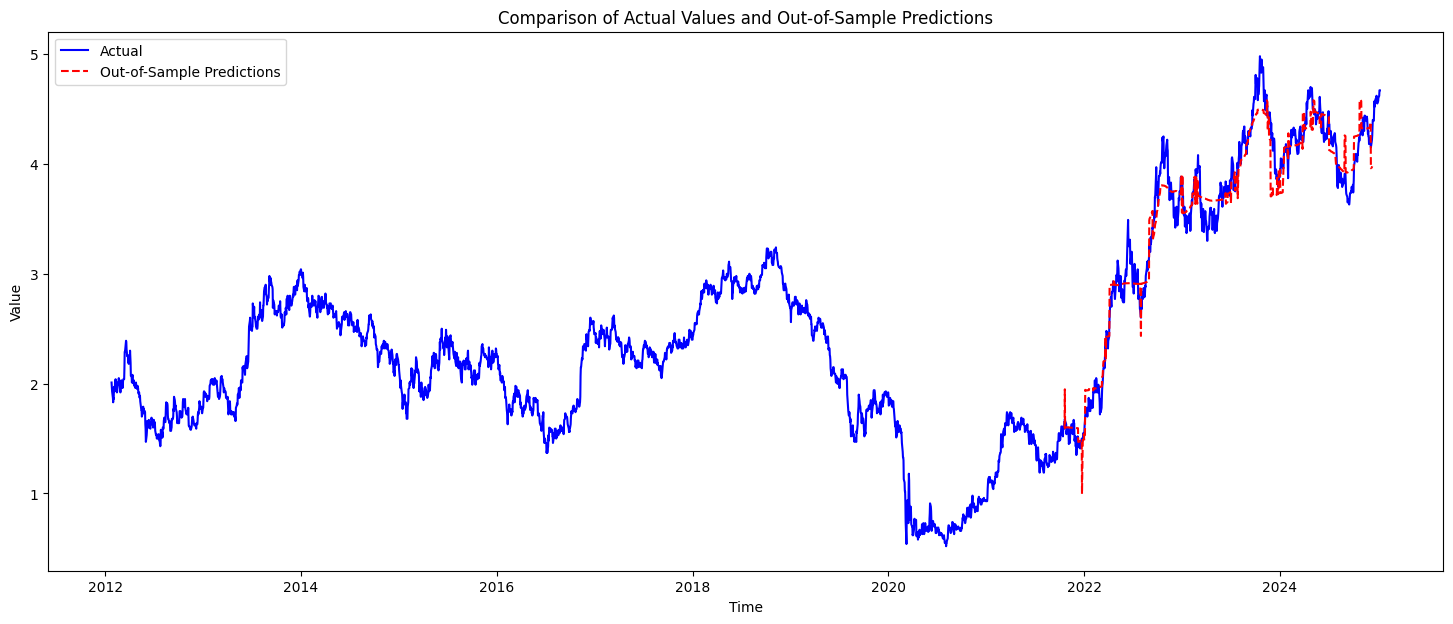

In [69]:
# Plot the actual y values against the out-of-sample predictions
plt.figure(figsize=(18, 7))
plt.plot(df_orig['US 10yr'], label='Actual', color='b')
plt.plot(oof_predictions, label='Out-of-Sample Predictions', color='r', linestyle='--')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Comparison of Actual Values and Out-of-Sample Predictions')
plt.show()

In [70]:
# make predictions with alternative values
X2 = df_orig[X.columns].tail(1).copy()
X2.loc[X2.index[0],'Net Liquidity Indicator'] = 6000847.0
print(best_tree.predict(X2))

[4.4529375]


c:\Users\dstockman\AppData\Local\Programs\Python\Python312\Lib\site-packages\shap\plots\_beeswarm.py:950: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  pl.tight_layout()


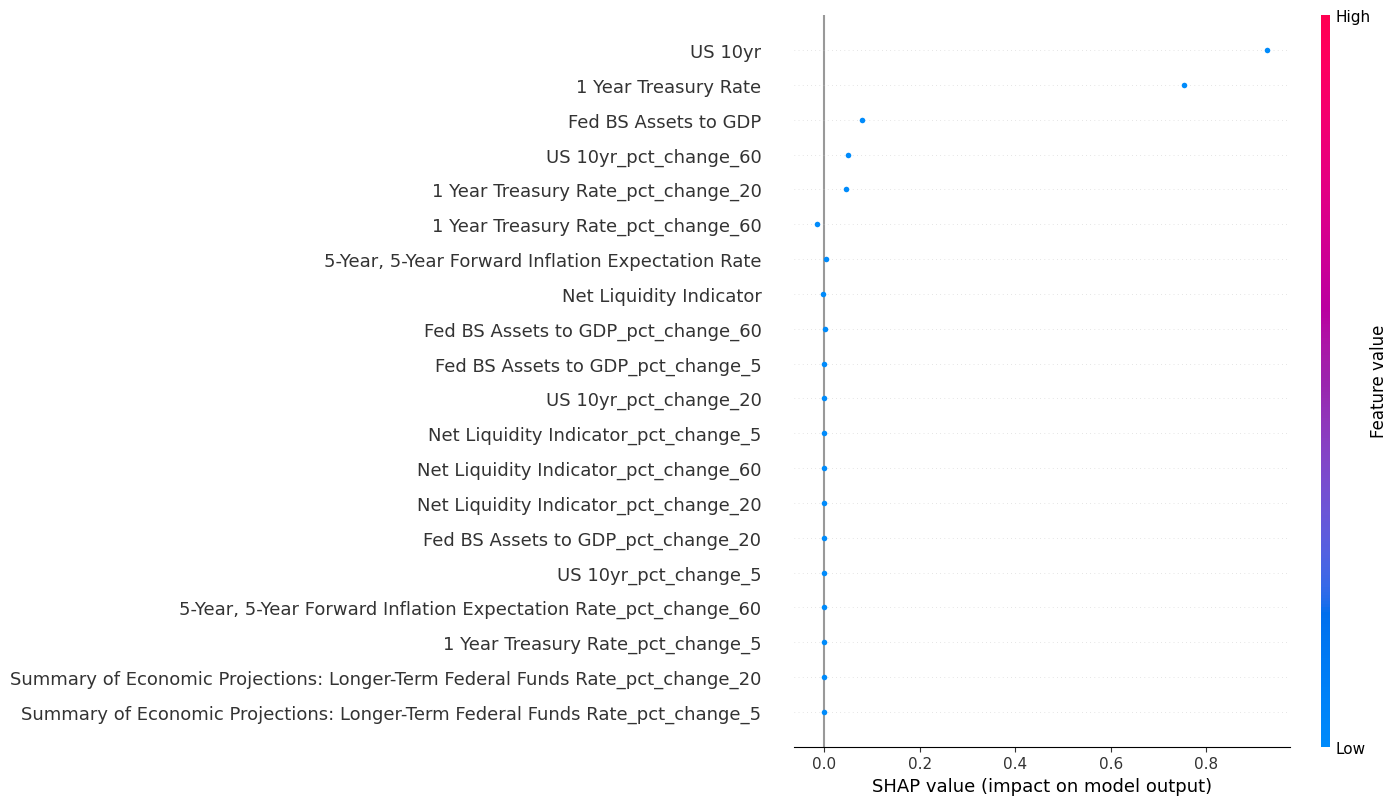

Predicted value: 4.452937500000001
SHAP predicted value: 4.4529375541127525


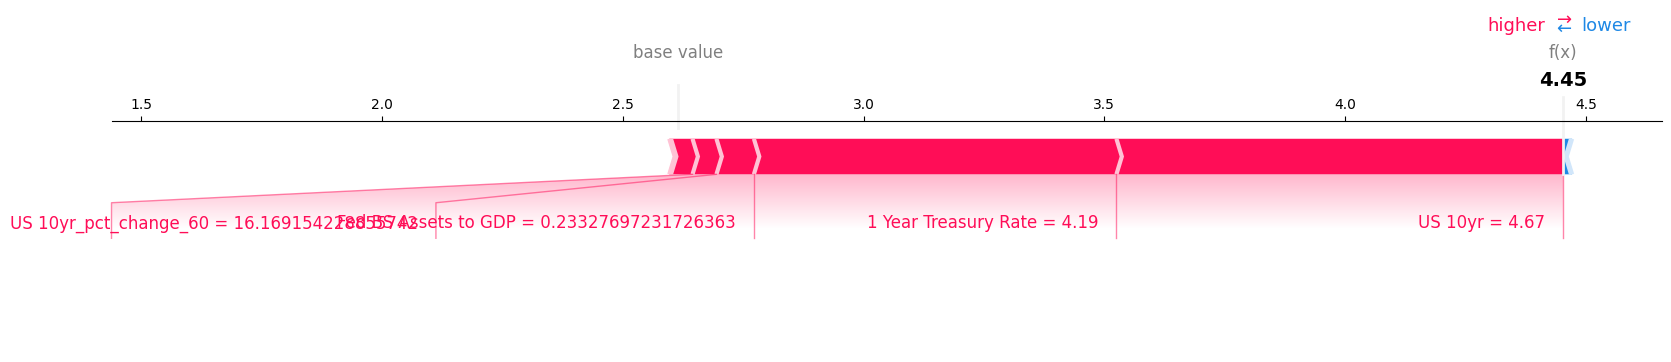

In [71]:
import shap

# Use SHAP to explain the model predictions
explainer = shap.Explainer(best_tree, X_train)
shap_values = explainer(X2)

# Plot summary plot
shap.summary_plot(shap_values, X_test)

# Plot SHAP values for a single prediction
#shap.force_plot(base_value=shap_values[0], features=X2.iloc[0, :], matplotlib=True)
# Plot force plot for a single prediction
#shap.force_plot(base_value=explainer.expected_value, shap_values=shap_values[0],  features=X2.iloc[0, :], matplotlib=True)
# Compare prediction and SHAP explanation for a specific instance
index = 0  # Index of the instance to compare
predicted_value = best_tree.predict(X2.iloc[index:index+1])[0]
shap_expected_value = explainer.expected_value
shap_predicted_value = shap_expected_value + shap_values[index].values.sum()

print("Predicted value:", predicted_value)
print("SHAP predicted value:", shap_predicted_value)

# Plot force plot for the specific instance
shap.force_plot(shap_expected_value, shap_values[index].values, X2.iloc[index, :], matplotlib=True)

c:\Users\dstockman\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


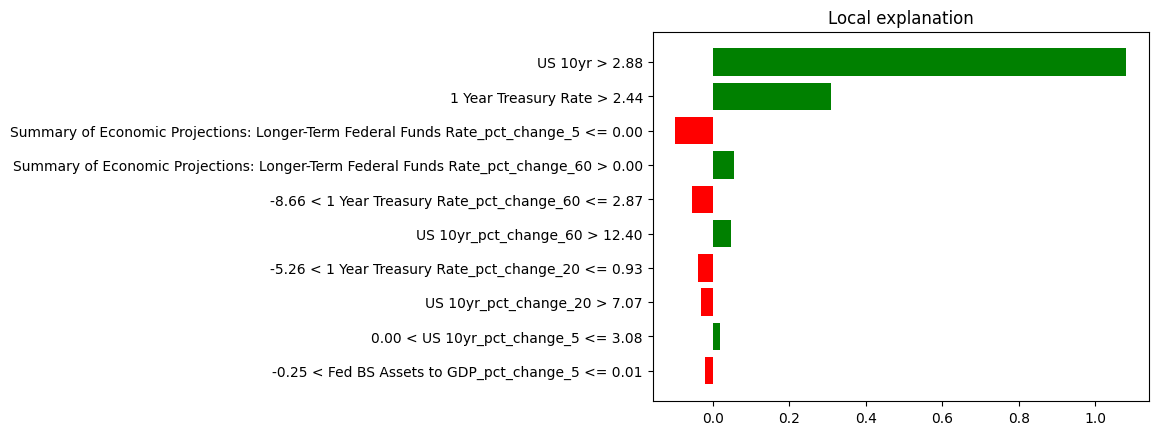

In [72]:
import lime
import lime.lime_tabular

# Use LIME to explain the model predictions
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X_train.columns,
    mode='regression'
)

# Choose a sample to explain
sample_index = 0
sample = X2.iloc[sample_index].values

# Explain the prediction
exp = explainer.explain_instance(
    data_row=sample,
    predict_fn=best_tree.predict
)

# Show the explanation in the notebook
exp.show_in_notebook(show_table=True)

# Plot the explanation using matplotlib
fig = exp.as_pyplot_figure()
plt.show()